In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import requests
import base64
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from scipy import signal
from scipy.io import wavfile
from torchsummary import summary
from skimage.transform import resize
from sklearn.metrics import precision_score, recall_score, f1_score
from torchsampler import ImbalancedDatasetSampler
import shutil
from math import ceil, floor
from sklearn.metrics import confusion_matrix


Wav to spectrogram

nperseg: 448 noverlap: 181
File: 4666.wav, Spectrogram shape: (224, 224)


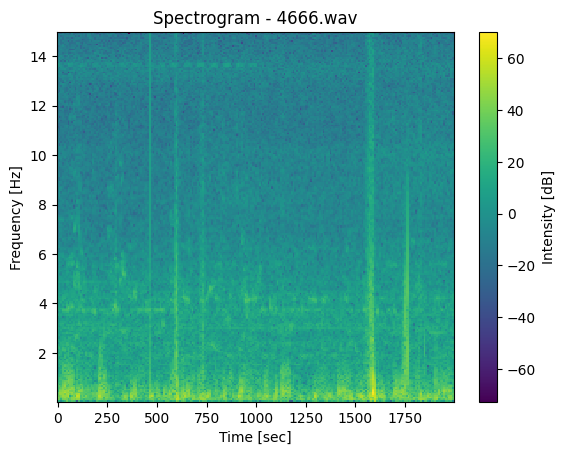

(7809, 1, 224, 224)


In [4]:
# Specify the folder path
#folder_path = '/content/drive/MyDrive/Colab_Notebooks/Project_Datasets/Train_Datasets'
folder_path = '/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/train2'

# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.wav')]





def calculate_noverlap():
  steth_sample_rate = 4000
  duration = 15
  total_samples = steth_sample_rate * duration
  num_freq_bins = 224
  num_time_steps = 224

  nperseg = 2 * num_freq_bins  # (Nyquist limit)

  # num_time_steps = (total samples - noverlap) / (nperseg - noverlap)
  # t = s - o / p - o
  # tp - to = s - o
  # o = (tp - s) / (t - 1)

  noverlap = round((num_time_steps * nperseg - total_samples) / (num_time_steps - 1))
  return int(nperseg), int(noverlap)

nperseg, noverlap = calculate_noverlap()
print("nperseg:", nperseg, "noverlap:", noverlap)

def plot_spectrogram(nperseg, noverlap, file_list, folder_path):
    
    # List to store all log_spectrograms
    all_spectrograms = []
    # Iterate through each .wav file in the folder
    for wav_file in file_list:
        # Construct the full path to the .wav file
        wav_file_path = os.path.join(folder_path, wav_file)

        # Read the WAV file
        sample_rate, samples = wavfile.read(wav_file_path)

        # Compute the spectrogram
        frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)

        # Apply logarithmic transformation
        log_spectrogram = resize(10 * np.log10(spectrogram+1e-10),(224,224))

        # Store the log_spectrogram in the list
        all_spectrograms.append(log_spectrogram)

    # Print the shape of the first spectrogram
    print(f"File: {file_list[0]}, Spectrogram shape: {all_spectrograms[0].shape}")

    # Ensure X has shape (225, 224) and Y has shape (224, 225)
    X, Y = np.meshgrid(times[:225], frequencies[:224], indexing='ij')

    #print(f"Original Spectrogram shape: {spectrogram.shape}")
    #print(f"Resized Spectrogram shape: {all_spectrograms[0].shape}")
    #print(f"X shape: {X.shape}")
    #print(f"Y shape: {Y.shape}")
    

    # Plot the first spectrogram
    plt.pcolormesh(Y, X, all_spectrograms[0], shading='auto')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'Spectrogram - {file_list[0]}')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

    return all_spectrograms

# Plot the spectrogram with calculated nperseg and noverlap
all_spectrograms = plot_spectrogram(nperseg, noverlap, file_list, folder_path)

all_resized_spectrograms = np.reshape(np.array(all_spectrograms), newshape=(7809,1,224,224))

print(all_resized_spectrograms.shape)

Converting to a binary encoded matrix based on .npy files in train2

In [5]:
# Specify the folder path for .npy files
folder_path_npy = '/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/train2'

# Get a list of all .npy files in the folder
npy_file_list = [f for f in os.listdir(folder_path_npy) if f.endswith('.npy')]

# List to store the binary-encoded matrices
binary_encoded_matrices = []

# Iterate through each .npy file
for npy_file in npy_file_list:
    # Construct the full path to the .npy file
    npy_file_path = os.path.join(folder_path_npy, npy_file)

    # Load the .npy file
    label_array = np.load(npy_file_path)

    # Check the presence of wheeze, stridor, and rhonchi
    wheeze_present = label_array[0] == 1
    stridor_present = label_array[1] == 1
    rhonchi_present = label_array[2] == 1

    # Create a binary-encoded vector
    if wheeze_present==0 and stridor_present==0 and rhonchi_present==0:
        binary_code = 0
    else: 
        binary_code = 1
    #binary_encoded_vector = [int(wheeze_present), int(stridor_present), int(rhonchi_present)]

    # Append the vector to the list
    binary_encoded_matrices.append(binary_code)

# Convert the list to a NumPy array and reshape
binary_encoded_matrix = np.array(binary_encoded_matrices).reshape(-1, 1)

# Print the resulting binary-encoded matrix
print(binary_encoded_matrix.shape)


(7809, 1)


Test data spectrograms

File: 1078.wav, Spectrogram shape: (224, 224)


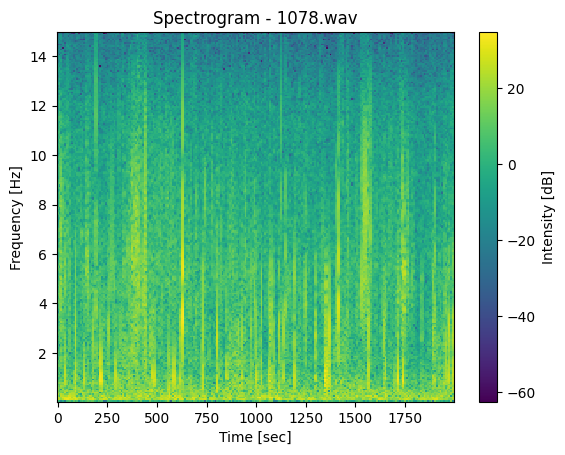

(1185, 1, 224, 224)


In [6]:
# Specify the folder path
#folder_path = '/content/drive/MyDrive/Colab_Notebooks/Project_Datasets/Train_Datasets'
folder_path_1 = '/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/test2'

# Get a list of all files in the folder
file_list1 = [f for f in os.listdir(folder_path_1) if f.endswith('.wav')]



# List to store all log_spectrograms
all_spectrograms_test = []

# Plot the spectrogram with calculated nperseg and noverlap
all_spectrograms_test = plot_spectrogram(nperseg, noverlap, file_list1, folder_path_1)

all_resized_spectrograms_test = np.reshape(np.array(all_spectrograms_test), newshape=(1185,1,224,224))

print(all_resized_spectrograms_test.shape)

Converting to a binary encoded matrix based on .npy files in test2

In [7]:
# Specify the folder path for .npy files
folder_path_npy = '/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/test2'

# Get a list of all .npy files in the folder
npy_file_list = [f for f in os.listdir(folder_path_npy) if f.endswith('.npy')]

# List to store the binary-encoded matrices
binary_encoded_matrices_test = []

# Iterate through each .npy file
for npy_file in npy_file_list:
    # Construct the full path to the .npy file
    npy_file_path = os.path.join(folder_path_npy, npy_file)

    # Load the .npy file
    label_array = np.load(npy_file_path)

    # Check the presence of wheeze, stridor, and rhonchi
    wheeze_present = label_array[0] == 1
    stridor_present = label_array[1] == 1
    rhonchi_present = label_array[2] == 1

    # Create a binary-encoded vector
    if wheeze_present==0 and stridor_present==0 and rhonchi_present==0:
        binary_code = 0
    else: 
        binary_code = 1
    #binary_encoded_vector = [int(wheeze_present), int(stridor_present), int(rhonchi_present)]

    # Append the vector to the list
    binary_encoded_matrices_test.append(binary_code)

# Convert the list to a NumPy array and reshape
binary_encoded_matrix_test = np.array(binary_encoded_matrices_test).reshape(-1, 1)

# Print the resulting binary-encoded matrix
print(binary_encoded_matrix_test.shape)


(1185, 1)


CustomDataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, samples, labels):
        """
        Initialize the CustomDataset with paired samples.

        Args:
            samples (list of tuples): A list of (x, y) pairs representing the dataset samples.
        """
        self.samples = torch.Tensor(samples).to(torch.float32)
        self.labels = torch.Tensor(labels).to(torch.float32)

    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of samples.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns the sample pairs corresponding to the given list of indices.

        Args:
            indices (list): A list of indices to retrieve samples for.

        Returns:
            list: A list of (x, y) pairs corresponding to the specified indices.
        """
        selected_sample = self.samples[idx]
        selected_label = self.labels[idx]
        return selected_sample , selected_label
    
    def get_labels(self):
        """
        Returns the labels of the dataset.
        """
        return self.labels

In [9]:
batch_size = 100
train_dataset = CustomDataset(all_resized_spectrograms,binary_encoded_matrix)

trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size , shuffle=True)#, sampler=train_sampler)


test_dataset = CustomDataset(all_resized_spectrograms_test,binary_encoded_matrix_test)

testloader = torch.utils.data.DataLoader(test_dataset,batch_size=1185 , shuffle=False)




In [10]:
class VGG16(nn.Module):
    def __init__(self, verbose=False):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc3 = nn.Linear(4096, 1)

        self.verbose = verbose

    def forward(self, x):
        if self.verbose:
            print(f"Input shape: {x.size()}")

        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        if self.verbose:
            print(f"After Layer 1: {x.size()}")

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        if self.verbose:
            print(f"After Layer 2: {x.size()}")

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)
        if self.verbose:
            print(f"After Layer 3: {x.size()}")

        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool4(x)
        if self.verbose:
            print(f"After Layer 4: {x.size()}")

        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool5(x)
        if self.verbose:
            print(f"After Layer 5 {x.size()}")

        x = torch.flatten(x,1)
        #x = torch.unsqueeze(1,x)
        if self.verbose:
            print(f"Flattened: {x.size()}")

        x = F.relu(self.fc1(x))
        if self.verbose:
            print(f"After first Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = F.relu(self.fc2(x))
        if self.verbose:
            print(f"After Secound Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = self.fc3(x)
        #x = torch.sigmoid(x)

        
        
        if self.verbose:
            print(f"Output shape: {x.size()}")

        return x

Check for GPU

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


Checking CNN shape

In [12]:
print("Intermediate shapes for VGG16")
model = VGG16(verbose=True)
output = model(torch.ones(size=(1,1,224,224)))
# More infor on VGG16 (https://builtin.com/machine-learning/vgg16)

Intermediate shapes for VGG16
Input shape: torch.Size([1, 1, 224, 224])
After Layer 1: torch.Size([1, 64, 112, 112])
After Layer 2: torch.Size([1, 128, 56, 56])
After Layer 3: torch.Size([1, 256, 28, 28])
After Layer 4: torch.Size([1, 512, 14, 14])
After Layer 5 torch.Size([1, 512, 7, 7])
Flattened: torch.Size([1, 25088])
After first Fully connected layer: torch.Size([1, 4096])
After dropout: torch.Size([1, 4096])
After Secound Fully connected layer: torch.Size([1, 4096])
After dropout: torch.Size([1, 4096])
Output shape: torch.Size([1, 1])


Train and test Loop with BCE_Loss

In [16]:
def train_loop_bce(model, criterion, optimizer, n_epoch, n_batches, print_every):
    
    loss_hist = np.zeros(n_epoch * n_batches)
    conf_matrix_hist = np.zeros((n_epoch * n_batches, 2, 2))
    accuracy_hist = np.zeros(n_epoch * n_batches)

    it = 0
    iter = 0


    for epoch in range(n_epoch):
    

        total = 0
        correct = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            inputs = inputs/255

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Store predictions and labels for evaluation
            predictions = (outputs > 0.5).float()

            print(labels)
            print(labels.shape)

            print(predictions)
            print(predictions.shape)

            predictions = predictions.view(-1, 1)
            print(predictions)
            print(predictions.shape)



            correct += np.sum(predictions.cpu().numpy() == np.argmax(labels.numpy(), axis=1))
            print("Correct:", correct)
            total += labels.size(0)
            print("Total:", total)
            accuracy = 100.0 * correct / total
            print("Accuracy:", accuracy)



            # Print statistics
            loss_hist[iter] = loss.item()

            # Calculate confusion matrix and accuracy
            conf_matrix = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy())
            

            conf_matrix_hist[iter] = conf_matrix
            accuracy_hist[iter] = accuracy

            iter += 1

            if (i + 1) % print_every == 0:
                print('epoch = {}/{}, minibatch = {}/{}, loss = {}, Accuracy = {}'.format(epoch+1,n_epoch,i + 1, n_batches, loss.item(), accuracy))
        
        it += 1

    print("Finished Training")
    return loss_hist, conf_matrix_hist, accuracy_hist


In [ ]:
model = VGG16()#.to(device)
criterion = nn.BCEWithLogitsLoss()#pos_weight=class_weights_tensor)
learning_rate = 0.01 
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-8)
n_epoch   = 5
n_batches = len(trainloader)
print_every = 1

loss_bce, accuracy_bce, confusion_matrix_bce = train_loop_bce(model,criterion,optimizer,n_epoch,n_batches,print_every)

In [ ]:
# Plot confusion matrix

classes = ['Normal', 'Abnormal']
sns.heatmap(confusion_matrix_bce, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes,
            yticklabels=classes)

plt.title('Train Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot training loss
axs[0].plot(loss_bce, label="Train Datasets")
axs[0].set_yscale('log')
axs[0].set_ylabel('Training Loss')
axs[0].legend()

# Plot accuracy
axs[1].plot(accuracy_bce, label="Accuracy", color='blue')
axs[1].set_ylabel('Accuracy')


axs[1].set_xlabel('Iterations')
axs[1].legend()

plt.show()


In [ ]:
def test_loop_bce(model, criterion, testloader):
    model.eval()  # Set the model to evaluation mode

    total_correct = 0
    total_samples = 0
    losses = []
    accuracy_hist = []

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            predictions = (outputs > 0.5).float()  # Convert to binary predictions
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Append the loss to the list
            losses.append(loss.item())

            # Calculate accuracy
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            accuracy = total_correct / total_samples *100.0
            accuracy_hist.append(accuracy)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, np.round(all_predictions))

    print(f'Test Accuracy: {accuracy:.4f}')

    return accuracy_hist, losses, conf_matrix

# Test loop
accuracy_hist_test, loss_hist_test, confusion_matrix_test = test_loop_bce(model, criterion, testloader)


In [ ]:
# Plot confusion matrix
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes,
            yticklabels=classes)

plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot training loss
axs[0].plot(loss_hist_test, label="Test Datasets")
axs[0].set_yscale('log')
axs[0].set_ylabel('Testing Loss')
axs[0].legend()

# Plot accuracy
axs[1].plot(accuracy_hist_test, label="Accuracy", color='blue')
axs[1].set_ylabel('Accuracy')



axs[1].set_xlabel('Iterations')
axs[1].legend()

plt.show()